# Grizli processing example for NIRISS WFSS data

- (16 Nov 2023) Very rough for now, I be going through to add Markdown comments

In [1]:
import os

path = '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo'
if os.path.exists(path):
    os.chdir(path)

In [2]:
import numpy as np
import glob

from grizli import utils
from grizli.aws import visit_processor

Set ROOT_PATH=/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo


In [3]:
import grizli
print('grizli version: ', grizli.__version__)

grizli version:  1.9.12.dev23+gbbbe43c.d20231112


## Find an association in the `grizli` database

Database schema is at https://s3.amazonaws.com/grizli-v2/DatabaseSchema/index.html.  The script below should work without the db access credentials going through the heroku API.

In [4]:
# Find association based on coordinates.  
# The demo here is a visit from the PASSAGE
# pure-parallel program GO-1571

ra, dec = 265.7449338, 67.0901598

find_assoc = utils.read_catalog(f"https://grizli-cutout.herokuapp.com/assoc?coords={ra},{dec}&output=csv", format='csv')

assoc = find_assoc['assoc_name'][0]

print(find_assoc)

              assoc_name               target proposal_id    proposal_pi        filter    instrument_name status
------------------------------------- ------- ----------- ------------------ ------------ --------------- ------
j174300p6705_f200w-clear-gr150r_00000 unknown        1571 Malkan, Matthew A. GR150R-F200W          NIRISS     70


In [5]:
_url = f'http://grizli-cutout.herokuapp.com/assoc_json?name={assoc}'
tab = utils.read_catalog(_url, format='pandas.json')

so = np.argsort(tab['t_min'])
print(tab['dataURL','ra','dec','instrument_name', 'filter', 't_min'][so])

                         dataURL                                ra            dec      instrument_name    filter         t_min      
--------------------------------------------------------- -------------- ------------- --------------- ------------ ----------------
mast:JWST/product/jw01571302001_04201_00001_nis_rate.fits  265.744097101 67.0899175442          NIRISS  CLEAR-F200W 60190.8977451504
mast:JWST/product/jw01571302001_04201_00002_nis_rate.fits  265.744483882 67.0905496563          NIRISS  CLEAR-F200W 60190.9005562499
mast:JWST/product/jw01571302001_04201_00003_nis_rate.fits 265.7434195735 67.0902923318          NIRISS  CLEAR-F200W 60190.9033562499
mast:JWST/product/jw01571302001_04201_00004_nis_rate.fits 265.7449759847  67.090190495          NIRISS  CLEAR-F200W  60190.906224398
mast:JWST/product/jw01571304001_08201_00001_nis_rate.fits  265.744063935 67.0898716193          NIRISS GR150R-F200W  60190.926167017
mast:JWST/product/jw01571304001_08201_00002_nis_rate.fits 265.7445415

# Run preprocessing

1. Download `rate` files from MAST to ``{assoc}/RAW``
1. 1/f correction and flag snowballs in DQ extensions
1. Run `AssignWcsStep`, `FlatFieldStep` and `PhotomStep` to direct imaging
    - Derive SIP WCS header from the `gwcs` properties
1. Adjust header keywords of the grism exposures to make them look like direct images and run `FlatFieldStep` to apply the imaging flat-field
1. Compute shifts between exposures, similar to TweakShifts
1. Align global astrometry to some reference catalog, here the default will be LegacySurveys DR9
    - Direct image alignment propagated to grism exposures
1. Subtract grism master sky

In [6]:
# Change a few grizli pipeline defaults
prep_args = {'oneoverf_kwargs': {'deg_pix':2048, 'dilate_iterations':3, 
                                 'thresholds':[5,4,3],
                                 'other_axis':False},
             'align_clip':32,
             # 'reference_catalogs':['LS_DR9'],
                              }

os.chdir(path)

visit_processor.process_visit(assoc, clean=False, sync=False,
                              with_db=False, # run without DB credentials
                              do_make_visit_mosaic=False,
                              prep_args=prep_args,
                             )


# Write parameters to j174300p6705_f200w-clear-gr150r_00000.run.yaml


# Write parameters to j174300p6705_f200w-clear-gr150r_00000.run.yaml



2023-11-15 23:06:09,125 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 5 of "solution didn't converge (Note 8)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



j174300p6705_f200w-clear-gr150r_00000 : found 34 GAIA sources
j174300p6705_f200w-clear-gr150r_00000.gaia.reg: x = ra, y=dec, ellipse=False
# (2023-11-16 04:06:09.148)

auto_script.fetch_files(**{'field_root': 'j174300p6705_f200w-clear-gr150r_00000', 'HOME_PATH': '$PWD', 'paths': {'home': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo', 'base': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000', 'raw': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/RAW', 'prep': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/Prep', 'persist': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/Persistence', 'extract': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/Extractions', 'thumbs': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-cle

2023-11-15 23:06:09,548 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]
# (2023-11-16 04:06:09.561)

jwst_utils.initialize_jwst_image(**{'filename': 'jw01571304001_08201_00003_nis_rate.fits', 'verbose': True, 'max_dq_bit': 14, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING'], 'oneoverf_correction': False, 'oneoverf_kwargs': {'make_plot': False}, 'use_skyflats': True, 'nircam_edge': 8})

ENV CRDS_CONTEXT = jwst_1123.pmap
PFLTFILE = /Users/gbrammer/Research/grizli/crds_cache/references/jwst/niriss/jwst_niriss_flat_0271.fits
Clip MAXDQBIT = 14
ENV CRDS_CONTEXT = jwst_1123.pmap
jwst_utils.img_with_flat: Flat already applied
jwst_utils.get_jwst_skyflat: /Users/gbrammer/Research/grizli/CONF/NircamSkyFlat/nis-f200w-gr150r_skyflat.fits not found
ENV CRDS_CONTEXT = jwst_1123.pmap
jwst.assign_wcs.AssignWcsStep: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0025.asdf


2023-11-15 23:06:12,161 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


jwst_utils.update_pure_parallel_wcs: NRS_FULL_IFU offset v2,v3 = -0.010, -0.082  dPA = 0.00 (dx**2 = 8.41e+00, nfev = 59)
jwst_utils.update_pure_parallel_wcs: jw01571304001_08201_00003_nis_rate.fits
jwst_utils.update_pure_parallel_wcs: prime jw01536003001_08101_00003_nrs1_cal.fits NRS_FULL_IFU
jwst_utils.update_pure_parallel_wcs: original crval 265.743453 67.090286
jwst_utils.update_pure_parallel_wcs:      new crval 265.742760 67.090219
jwst_utils.update_pure_parallel_wcs:           dpix -7.696 -13.207
# photometry keywords
PHOTFNU = 2.6747e-08
PHOTPLAM = 19929.6
PHOTFLAM = 2.0135e-21
ZP = 27.83
TO_MJYSR = 0.265

# (2023-11-16 04:06:12.592)

jwst_utils.set_jwst_to_hst_keywords(**{'input': 'jw01571304001_08201_00003_nis_rate.fits', 'reset': True, 'verbose': True, 'orig_keys': ['TELESCOP', 'INSTRUME', 'DETECTOR', 'FILTER', 'PUPIL', 'EXP_TYPE', 'GRATING']})

Reset: TELESCOP > JWST (OTELESCO)
Reset: INSTRUME > NIRISS (OINSTRUM)
Reset: DETECTOR > NIS (ODETECTO)
Reset: FILTER > GR150R (OFILT

cp: *mask.reg: No such file or directory


** Combine Singles: **
0 indef-01571-302-106.0-nis-f200w-clear 4
1 indef-01571-304-106.0-nis-f200w-gr150r 4
NIRISS pure parallel direct:  indef-01571-302-106.0-nis-f200w-clear

 == Grism groups ==

indef-01571-302-106.0-nis-f200w-clear 4 indef-01571-304-106.0-nis-f200w-gr150r 4
Initial exposure footprints in ./j174300p6705_f200w-clear-gr150r_00000_visits.yaml
# (2023-11-16 04:06:26.240)

auto_script.preprocess(**{'field_root': 'j174300p6705_f200w-clear-gr150r_00000', 'HOME_PATH': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo', 'PERSIST_PATH': '/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': 'astrometry_db', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_

In [6]:
os.chdir(os.path.join(path, assoc, 'Prep'))
os.getcwd()

'/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/Prep'

In [7]:
# Astrometric alignment
! cat *wcs.log

# ext xshift yshift rot scale rms N
# radec: indef-01571-302-106.0-nis-f200w-clear_ls_dr9.radec
# indef-01571-302-106.0-nis-f200w-clear
    0       -7.5715      -16.9439       -0.0323       1.00000         0.565   32


# Make image mosaic and catalog

In [8]:
import glob
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from grizli import prep

In [9]:
files = glob.glob('*rate.fits')

res = visit_processor.res_query_from_local()

hdu = utils.make_maximal_wcs(files=files, pixel_scale=0.05, pad=16, get_hdu=True)
wcs = pywcs.WCS(hdu.header)

root = assoc.split('_')[0]

visit_processor.cutout_mosaic(root,
                              ir_wcs=wcs, half_optical=False,
                              kernel='square', pixfrac=0.8,
                              res=res,
                              clean_flt=False,
                              s3output=None,
                              make_exptime_map=False,
                              weight_type='jwst'
                             )

2023-11-15 23:18:03,393 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.464619 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.386471 from OBSGEO-[XYZ].
Set OBSGEO-H to 1403325743.867 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-11-15 23:18:03,405 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.461138 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.383773 from OBSGEO-[XYZ].
Set OBSGEO-H to 1403293405.660 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-11-15 23:18:03,417 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.457670 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.381085 from OBSGEO-[XYZ].
Set OBSGEO-H to 1403261195.2

  0/  8: jw01571304001_08201_00001_nis_rate.fits[SCI,1]    5.10
  1/  8: jw01571302001_04201_00001_nis_rate.fits[SCI,1]    5.10
  2/  8: jw01571304001_08201_00002_nis_rate.fits[SCI,1]    5.20
  3/  8: jw01571302001_04201_00002_nis_rate.fits[SCI,1]    5.20
  4/  8: jw01571302001_04201_00003_nis_rate.fits[SCI,1]    5.24
  5/  8: jw01571304001_08201_00003_nis_rate.fits[SCI,1]    5.24
  6/  8: jw01571302001_04201_00004_nis_rate.fits[SCI,1]    5.28
  7/  8: jw01571304001_08201_00004_nis_rate.fits[SCI,1]    5.28

  Mosaic WCS: (265.74442,67.09022) 3.1'x3.1'  0.050"/pix

Fix NIRISS: filters = F200W-GR150R F200WN-CLEAR
Skip j174300p6705-f200w-gr150r
Skip j174300p6705-f200wn-clear


dataset,extension,sciext,assoc,filter,pupil,exptime,footprint,detector
str29,str4,int64,str6,str12,str5,float64,str93,str3
jw01571302001_04201_00001_nis,rate,1,manual,F200W-CLEAR,F200W,128.841,"((265.685039,67.077213),(265.777273,67.066874),(265.803275,67.102588),(265.710988,67.112944))",NIS
jw01571302001_04201_00002_nis,rate,1,manual,F200W-CLEAR,F200W,128.841,"((265.685564,67.077835),(265.777800,67.067495),(265.803804,67.103209),(265.711514,67.113566))",NIS
jw01571302001_04201_00003_nis,rate,1,manual,F200W-CLEAR,F200W,128.841,"((265.684515,67.077592),(265.776751,67.067253),(265.802752,67.102967),(265.710463,67.113323))",NIS
jw01571302001_04201_00004_nis,rate,1,manual,F200W-CLEAR,F200W,128.841,"((265.686091,67.077455),(265.778325,67.067115),(265.804329,67.102829),(265.712041,67.113186))",NIS
jw01571304001_08201_00001_nis,rate,1,manual,F200W-GR150R,F200W,515.365,"((265.685048,67.077218),(265.777281,67.066879),(265.803284,67.102593),(265.710996,67.112949))",NIS
jw01571304001_08201_00002_nis,rate,1,manual,F200W-GR150R,F200W,515.365,"((265.685571,67.077841),(265.777807,67.067502),(265.803810,67.103216),(265.711521,67.113573))",NIS
jw01571304001_08201_00003_nis,rate,1,manual,F200W-GR150R,F200W,515.365,"((265.684528,67.077598),(265.776763,67.067259),(265.802765,67.102973),(265.710476,67.113330))",NIS
jw01571304001_08201_00004_nis,rate,1,manual,F200W-GR150R,F200W,515.365,"((265.686091,67.077462),(265.778326,67.067122),(265.804329,67.102836),(265.712042,67.113193))",NIS


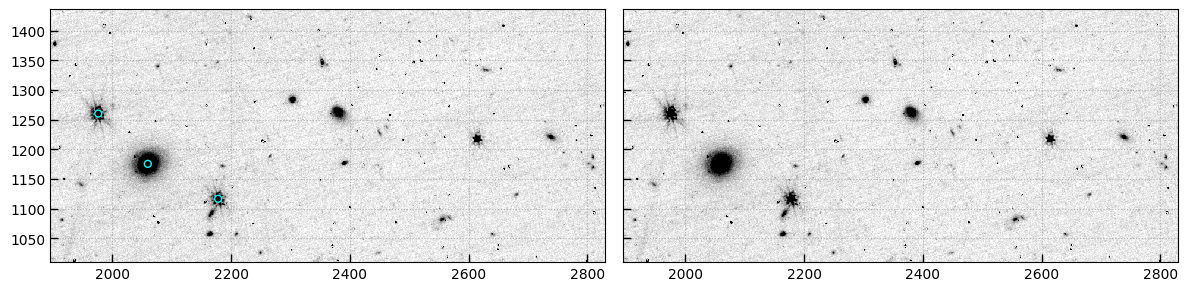

In [10]:
# Show images
files = glob.glob(root+'*sci.fits')
files.sort()

fig, axes = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True)

for ax, file in zip(axes, files[::-1]):
    with pyfits.open(file) as im:
        ax.imshow(im[0].data, vmin=-0.1, vmax=1, cmap='gray_r')
    ax.set_xlim(1895, 2830)
    ax.set_ylim(1010, 1436)
    ax.grid()

# Alignment sources
gaia = utils.read_catalog(f'indef-01571-302-106.0-nis-f200w-clear_ls_dr9.radec')
xg, yg = wcs.all_world2pix(gaia['ra'], gaia['dec'], 0)
axes[0].scatter(xg, yg, fc='None', ec='cyan', s=100)

fig.tight_layout(pad=1)

In [11]:
# Make catalog & segmentation image
cat  = prep.make_SEP_catalog(root + '-f200wn-clear', threshold=1.5)

! ln -s {root}-f200wn-clear_drc_sci.fits {root}-ir_drc_sci.fits 
! ln -s {root}-f200wn-clear.cat.fits {root}-ir.cat.fits 
! ln -s {root}-f200wn-clear_seg.fits {root}_seg.fits 


make_SEP_catalog: sep version = 1.2.1
# (2023-11-16 04:18:08.114)
sep: Image AB zeropoint =  28.900
# (2023-11-16 04:18:08.250)
SEP: Get background {'bw': 32.0, 'bh': 32.0, 'fw': 3, 'fh': 3}
SEP: err_scale=0.631
   SEP: Extract...
    Done.
compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.04999999999999819; subpix=0; flux_radii=[0.2, 0.5, 0.9]
# SEP j174300p6705-f200wn-clear.cat.fits: 3521 objects
ln: j174300p6705-ir_drc_sci.fits: File exists
ln: j174300p6705-ir.cat.fits: File exists
ln: j174300p6705_seg.fits: File exists


In [6]:
import os
os.chdir('/Users/gbrammer/Research/JWST/Projects/grizli-wfss-demo/j174300p6705_f200w-clear-gr150r_00000/Prep')
root = 'j174300p6705'

In [8]:
from grizli.pipeline import auto_script
import warnings

warnings.filterwarnings('ignore')

! rm *GrismFLT* ../Extractions/*
    
auto_script.grism_prep(field_root=root,
                       pad=(1024,1024),
                       use_jwst_crds=False,
                       prelim_mag_limit=26,
                       refine_mag_limits=[18,22],
                      )

rm: *GrismFLT*: No such file or directory
rm: ../Extractions/*: No such file or directory
# (2023-11-16 04:23:08.496)

auto_script.grism_prep(**{'field_root': 'j174300p6705', 'PREP_PATH': '../Prep', 'EXTRACT_PATH': '../Extractions', 'ds9': None, 'refine_niter': 3, 'gris_ref_filters': {'G141': ['F140W', 'F160W', 'F125W', 'F105W', 'F110W', 'F098M', 'F127M', 'F139M', 'F153M', 'F132N', 'F130N', 'F128N', 'F126N', 'F164N', 'F167N'], 'G102': ['F105W', 'F098M', 'F110W', 'F125W', 'F140W', 'F160W', 'F127M', 'F139M', 'F153M', 'F132N', 'F130N', 'F128N', 'F126N', 'F164N', 'F167N'], 'G800L': ['F814W', 'F850LP', 'F606W', 'F435W', 'F775W', 'F555W', 'opt'], 'GR150C': ['F115W', 'F150W', 'F200W', 'CLEAR-F115W', 'CLEAR-F150W', 'CLEAR-F200W'], 'GR150R': ['F115W', 'F150W', 'F200W', 'CLEAR-F115W', 'CLEAR-F150W', 'CLEAR-F200W'], 'GRISMR': ['F277W-CLEAR', 'F356W-CLEAR', 'F410M-CLEAR', 'F444W-CLEAR', 'F277W', 'F356W', 'F410M', 'F444W'], 'GRISMC': ['F277W-CLEAR', 'F356W-CLEAR', 'F410M-CLEAR', 'F444W-CLEAR', 'F27

2023-11-15 23:23:22,351 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.426647 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.357036 from OBSGEO-[XYZ].
Set OBSGEO-H to 1402973062.487 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-11-15 23:23:22,426 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/units/core.py:2123: UnitsWarning: 'FLAM CGS per ELECTRON/S' did not parse as fits unit: At col 0, Unit 'FLAM' not supported by the FITS standard. Did you mean flm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

2023-11-15 23:23:22,427 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310

jw01571304001_08201_00001_nis_rate.fits: _compute_model Done
jw01571304001_08201_00002_nis_rate.fits: _compute_model Done
jw01571304001_08201_00003_nis_rate.fits: _compute_model Done
jw01571304001_08201_00004_nis_rate.fits: _compute_model Done
Models computed - 41.09 sec.
Save jw01571304001_08201_00001_nis.01.GrismFLT.fits
Save jw01571304001_08201_00002_nis.01.GrismFLT.fits
Save jw01571304001_08201_00003_nis.01.GrismFLT.fits
Save jw01571304001_08201_00004_nis.01.GrismFLT.fits
# grism_mode_bg jw01571304001_08201_00001_nis_rate.fits GR150R 0.0064
# grism_mode_bg jw01571304001_08201_00002_nis_rate.fits GR150R 0.0133
# grism_mode_bg jw01571304001_08201_00003_nis_rate.fits GR150R 0.0052
# grism_mode_bg jw01571304001_08201_00004_nis_rate.fits GR150R 0.0076
# (2023-11-16 04:24:05.181)
# Refine contamination

Refine contamination model, iter # 0

 3355 mag= 18.01 -5.27e-17  9.18e-17
 3357 mag= 18.08  2.13e-17 -1.80e-17
 2025 mag= 18.17  2.61e-17 -1.12e-17
 3350 mag= 18.20  4.53e-17 -3.42e-17
 

# Initialize from saved products

In [16]:
import glob
from grizli import multifit

os.chdir('../Extractions')
grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'),
                        seg_file=glob.glob('*seg.fits')[0],
                        catalog=glob.glob('*ir.cat.fits')[0],
                                )

2023-11-15 23:37:06,587 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.399467 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.335965 from OBSGEO-[XYZ].
Set OBSGEO-H to 1402720740.410 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-11-15 23:37:06,587 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.408498 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.342967 from OBSGEO-[XYZ].
Set OBSGEO-H to 1402804573.838 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-11-15 23:37:06,587 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py310jw/lib/python3.10/site-packages/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -44.426647 from OBSGEO-[XYZ].
Set OBSGEO-B to   -12.357036 from OBSGEO-[XYZ].
Set OBSGEO-H to 1402973062.4

Load jw01571304001_08201_00003_nis.01.GrismFLT.fits!


Transform JWST WFSS: flip=True
Load jw01571304001_08201_00002_nis.01.GrismFLT.fits!


Transform JWST WFSS: flip=True
Load jw01571304001_08201_00001_nis.01.GrismFLT.fits!


Transform JWST WFSS: flip=True
Load jw01571304001_08201_00004_nis.01.GrismFLT.fits!


Transform JWST WFSS: flip=True
Files loaded - 26.83 sec.


In [21]:
# Make diagnostic grism mosaic
grp.drizzle_grism_models(root=root)

j174300p6705-f200w-286.0_grism_sci.fits
# (2023-11-16 04:40:25.063)
Drizzle array 1/4
# (2023-11-16 04:40:26.744)
Drizzle array 2/4
# (2023-11-16 04:40:28.433)
Drizzle array 3/4
# (2023-11-16 04:40:30.115)
Drizzle array 4/4
j174300p6705-f200w-286.0_grism_clean.fits
# (2023-11-16 04:40:31.829)
Drizzle array 1/4
# (2023-11-16 04:40:33.509)
Drizzle array 2/4
# (2023-11-16 04:40:35.193)
Drizzle array 3/4
# (2023-11-16 04:40:36.879)
Drizzle array 4/4


# Extract a spectrum

In [76]:
args = auto_script.generate_fit_params(field_root=root, include_photometry=False,
                                       min_sens=1.e-4, min_mask=1.e-4,
                                       pline={'kernel': 'square', 'pixfrac': 0.2, 'pixscale': 0.06, 'size': 8, 'wcs': None}

                                      )

Saved arguments to fit_args.npy.


j174300p6705_00937.beams.fits


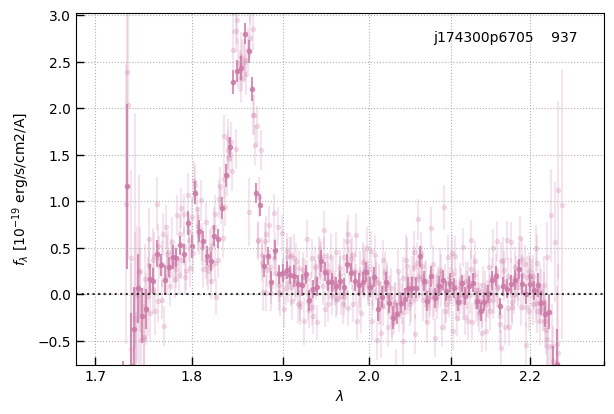

In [79]:
import numpy as np

ra, dec = 265.7593728, 67.0813350


# import grizli.ds9
# ds9 = grizli.ds9.DS9()
# ra, dec = np.cast[float](ds9.get('pan fk5').split())

dr = np.sqrt((grp.catalog['RA']-ra)**2 + (grp.catalog['DEC'] - dec)**2)
id = grp.catalog['NUMBER'][np.argmin(dr)]

# print(ra, dec, id, dr.min())

beams = grp.get_beams(id, size=32,
                        min_sens=args['min_sens'], min_mask=args['min_mask'],
                     )

mb = multifit.MultiBeam(beams, group_name=root,
                        fcontam=args['fcontam'],
                        min_sens=args['min_sens'], min_mask=args['min_mask'])


_ = mb.oned_figure()

mb.write_master_fits()

Run id=937 with fit_args.npy
load_master_fits: j174300p6705_00937.beams.fits
1 jw01571304001_08201_00002_nis_rate.fits GR150R
2 jw01571304001_08201_00003_nis_rate.fits GR150R
3 jw01571304001_08201_00004_nis_rate.fits GR150R
4 jw01571304001_08201_00001_nis_rate.fits GR150R
Trace shift

 [ 0.00]   2.33
 [-1.18]   2.44
 [ 1.18]   2.26
 [ 2.64]   2.42
 [ 0.81]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 1.89]   2.33
 [-1.18]   2.44
 [ 1.18]   2.26
 [ 2.64]   2.42
 [ 0.81]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [-1.18]   2.44
 [ 1.18]   2.26
 [ 2.64]   2.42
 [ 0.81]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.89]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]   2.25
 [ 0.94]  

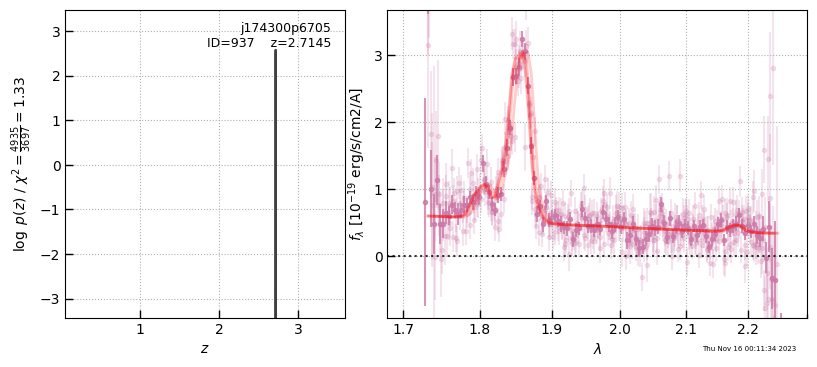

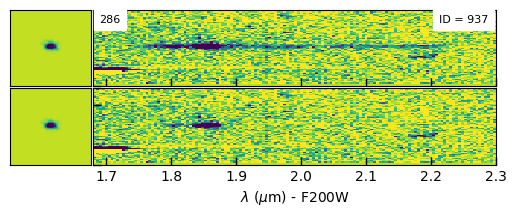

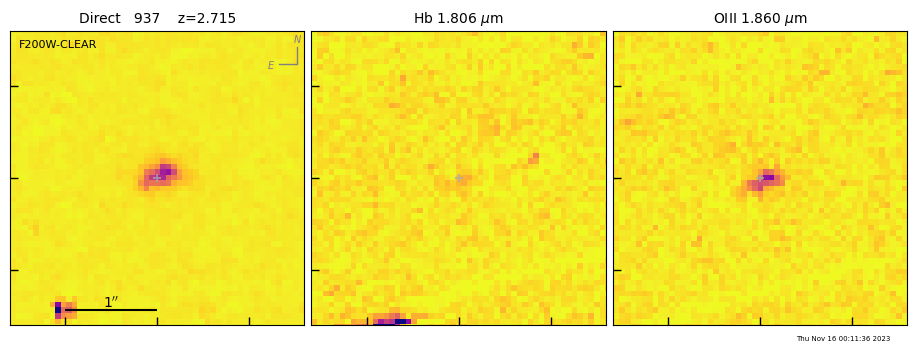

In [80]:
# Fit redshift
from grizli import fitting

_ = fitting.run_all_parallel(id, verbose=True, get_output_data=True, #zr=[1.5, 2.5], #zr=[0.01, 3.8], 
                            dscale=0.1, scale_linemap=0.1,
                             fit_trace_shift=True,
                            )